In [59]:
from __future__ import print_function, division
import os
import torch
import os
import torch
from torch import nn
import pandas as pd
import torchvision
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
import glob
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import tqdm

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [27]:
from tensorflow.python.client import device_lib; device_lib.list_local_devices()

ModuleNotFoundError: No module named 'tensorflow'

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

def save_result(images: np.ndarray, out_path: str):
    
    assert images.shape == (400, 3, 48, 48)
    
    flat_img = images.reshape(400, -1)
    n_rows = np.prod(images.shape)
    
    y_with_id = np.concatenate([np.arange(n_rows).reshape(-1, 1), flat_img.reshape(n_rows, 1)], axis=1)
    np.savetxt(out_path, y_with_id, delimiter=",", fmt=['%d', '%.4f'], header="id,predicted", comments='')


def plot_digits(view_data, decoded_data=None, image_size=48):
    n_rows = 2 if decoded_data is not None else 1
    n_cols = len(view_data)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))

    if decoded_data is not None:
        for i in range(n_cols):
            axes[0][i].imshow(np.reshape(view_data.data.numpy()[i], (image_size, image_size , 3)))
            axes[0][i].set_xticks(())
            axes[0][i].set_yticks(())

        for i in range(n_cols):
            axes[1][i].clear()
            axes[1][i].imshow(np.reshape(decoded_data.data.numpy()[i], (image_size, image_size, 3)))
            axes[1][i].set_xticks(())
            axes[1][i].set_yticks(())

    else:
        for i in range(n_cols):
            axes[i].imshow(np.reshape(view_data.data.numpy()[i], (image_size, image_size, 3)))
            axes[i].set_xticks(())
            axes[i].set_yticks(())


    plt.show()

In [67]:
class DenoisingDataset(Dataset):

    def __init__(self, data_dir, transform=None, train=True):
        self.train= train 
        self.x_path = os.path.join(data_dir, 'clean')
        self.y_path = os.path.join(data_dir, 'distorted')
        self.x_test_path = os.path.join(data_dir, 'test_distorted')
        self.x_files_paths = glob.glob(os.path.join(self.x_path, '*.jpg'))
        self.y_files_paths = glob.glob(os.path.join(self.y_path, '*.jpg'))
        self.x_test_files_paths = glob.glob(os.path.join(self.x_test_path, '*.jpg'))
        self.transform = transform
        self.train_data = []
        self.test_data = []

    def __len__(self):
        return len(self.x_files_paths)

    def __getitem__(self, idx):
        if self.train: 
            x_img_name, y_img_name =  self.x_files_paths[idx], self.y_files_paths[idx]
            x_image, y_image = io.imread(x_img_name), io.imread(y_img_name)
            x = self.transform(x_image)
            y = self.transform(y_image)
            self.train_data.append(x)
            return x,y
            
        else:
            x_test_img_name =  self.x_test_files_paths[idx]
            x_test_image = io.imread(x_test_img_name)
            x = self.transform(x_test_image)
            self.test_data.append(x)
            return x
        
    def get_train_data(self, num):
        return torch.stack(self.train_data[:num])
    
    def get_test_data(self, num):
        return torch.stack(self.test_data[:num])

In [68]:
data_path = os.path.join(os.getcwd(), 'data')

In [69]:
train_dataset = DenoisingDataset(data_path, 
                                 transform=transforms.Compose([
                                     torchvision.transforms.ToTensor(),
#                                      torchvision.transforms.Lambda(lambda x: x.flatten())
                                ]))
batch_size = 32
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
print(next(iter(train_loader))[0].shape)

torch.Size([32, 3, 48, 48])


In [71]:
train_dataset.get_train_data(5).shape

torch.Size([5, 3, 48, 48])

In [30]:
dataset.y_files_paths[0]

'/home/michal/Studia/2_semester/SolPushinRep/nn2019/3_kaggle_denoising/data/distorted/448.jpg'

In [31]:
def show_img(image):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.pause(0.001)  # pause a bit so that plots are updated
    

0 (48, 48, 3) (48, 48, 3)


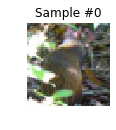

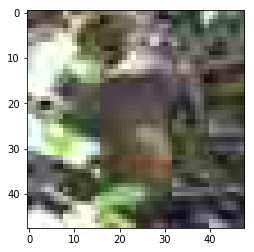

1 (48, 48, 3) (48, 48, 3)


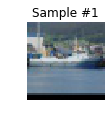

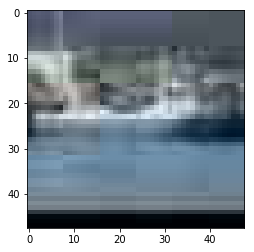

2 (48, 48, 3) (48, 48, 3)


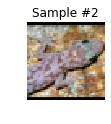

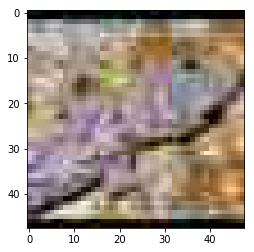

3 (48, 48, 3) (48, 48, 3)


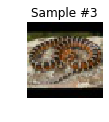

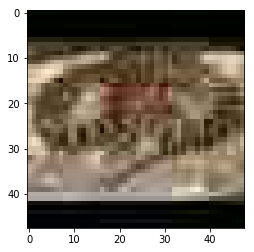

In [32]:
fig = plt.figure()

for i in range(len(dataset)):
    sample = dataset[i]

    print(i, sample['x'].shape, sample['y'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_img(sample['x'])
    show_img(sample['y'])

    if i == 3:
        plt.show()
        break

In [36]:
batch_size = 32

In [37]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

In [36]:
class AutoEncoder(torch.nn.Module):
    
    def __init__(self, latent_dim, image_size, channel_num):
        
        super(AutoEncoder, self).__init__()
        
        self.latent_dim = latent_dim
        
        self.encoder = nn.Sequential(
            nn.Linear( channel_num * image_size * image_size, 128),
            nn.Tanh(),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64, 12),
            nn.Tanh(),
            nn.Linear(12, self.latent_dim),
          ) 
        
        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dim, 12),
            nn.Tanh(),
            nn.Linear(12, 64),
            nn.Tanh(),
            nn.Linear(64, 128),
            nn.Tanh(),
            nn.Linear(128, image_size * image_size * channel_num),
            nn.Sigmoid()
          )
        
    def decode(self, z):
        return self.decoder(z)
    
    def encode(self, x):
        return self.encoder(x)

    def forward(self, x):
        en_out = self.encode(x)
        de_out = self.decode(en_out)
        return en_out, de_out


0it [00:00, ?it/s]

Epoch:  0 | train loss: 0.0733


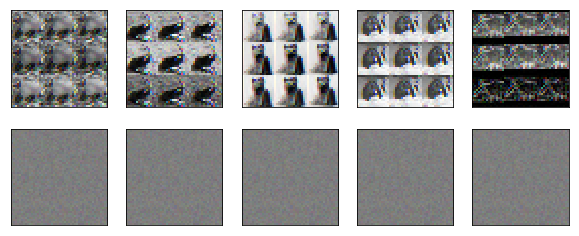


1it [00:00,  1.70it/s]
2it [00:00,  2.19it/s]
3it [00:00,  2.84it/s]
4it [00:00,  3.58it/s]
5it [00:01,  4.32it/s]
6it [00:01,  5.14it/s]
7it [00:01,  5.83it/s]
8it [00:01,  6.55it/s]
10it [00:01,  7.60it/s]
11it [00:01,  7.63it/s]
12it [00:01,  7.19it/s]
13it [00:01,  7.28it/s]
15it [00:02,  8.31it/s]
16it [00:02,  8.63it/s]
18it [00:02,  9.52it/s]
20it [00:02,  9.06it/s]
21it [00:02,  8.19it/s]
22it [00:02,  8.42it/s]
23it [00:03,  7.81it/s]
24it [00:03,  7.12it/s]
25it [00:03,  7.01it/s]
26it [00:03,  6.93it/s]
27it [00:03,  6.54it/s]
28it [00:03,  6.98it/s]
29it [00:03,  7.52it/s]
31it [00:04,  8.32it/s]
32it [00:04,  8.74it/s]
33it [00:04,  8.99it/s]
34it [00:04,  9.23it/s]
35it [00:04,  9.36it/s]
36it [00:04,  9.44it/s]
37it [00:04,  9.24it/s]
38it [00:04,  7.90it/s]
39it [00:05,  7.69it/s]
40it [00:05,  7.72it/s]
41it [00:05,  7.88it/s]
42it [00:05,  8.23it/s]
43it [00:05,  8.46it/s]
44it [00:05,  8.60it/s]
45it [00:05,  8.61it/s]
46it [00:05,  8.91it/s]
47it [00:05,  9.18it/s]

Epoch:  0 | train loss: 0.0628


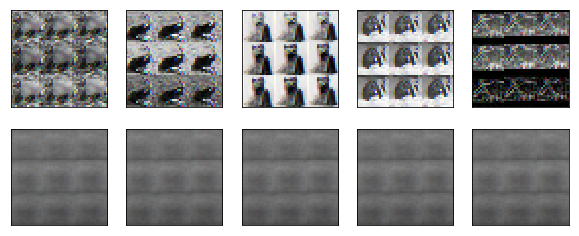


102it [00:12,  5.87it/s]
104it [00:12,  7.07it/s]
106it [00:13,  7.55it/s]
107it [00:13,  7.91it/s]
109it [00:13,  9.07it/s]
111it [00:13, 10.08it/s]
113it [00:13, 10.41it/s]
115it [00:13, 10.57it/s]
117it [00:13, 10.87it/s]
119it [00:14, 11.42it/s]
121it [00:14, 12.04it/s]
123it [00:14, 12.39it/s]
125it [00:14, 12.60it/s]
127it [00:14, 12.83it/s]
129it [00:14, 13.11it/s]
131it [00:14, 13.07it/s]
133it [00:15, 13.19it/s]
135it [00:15, 12.69it/s]
137it [00:15, 11.23it/s]
139it [00:15, 11.42it/s]
141it [00:15, 11.77it/s]
143it [00:16, 12.31it/s]
145it [00:16, 12.57it/s]
147it [00:16, 12.90it/s]
149it [00:16, 12.96it/s]
151it [00:16, 12.91it/s]
153it [00:16, 13.14it/s]
155it [00:16, 13.32it/s]
157it [00:17, 13.17it/s]
159it [00:17, 13.24it/s]
161it [00:17, 13.44it/s]
163it [00:17, 13.29it/s]
165it [00:17, 13.43it/s]
167it [00:17, 13.14it/s]
169it [00:17, 13.15it/s]
171it [00:18, 13.26it/s]
173it [00:18, 13.16it/s]
175it [00:18, 13.33it/s]
177it [00:18, 12.95it/s]
179it [00:18, 13.01it/s]

Epoch:  0 | train loss: 0.0508


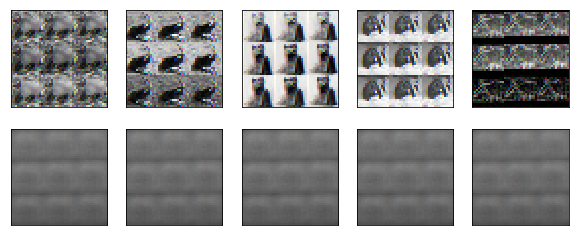


201it [00:21,  5.93it/s]
203it [00:21,  6.96it/s]
205it [00:21,  7.90it/s]
207it [00:21,  8.70it/s]
209it [00:21,  9.43it/s]
211it [00:21,  9.64it/s]
213it [00:22, 10.50it/s]
215it [00:22, 10.49it/s]
217it [00:22, 10.35it/s]
219it [00:22, 10.03it/s]
221it [00:22,  9.71it/s]
222it [00:23,  9.40it/s]
223it [00:23,  9.28it/s]
224it [00:23,  9.17it/s]
225it [00:23,  8.96it/s]
226it [00:23,  8.85it/s]
228it [00:23,  9.56it/s]
230it [00:23,  9.78it/s]
231it [00:24,  9.68it/s]
232it [00:24,  9.50it/s]
234it [00:24, 10.18it/s]
236it [00:24, 11.08it/s]
238it [00:24, 11.71it/s]
240it [00:24, 12.11it/s]
242it [00:24, 12.54it/s]
244it [00:25, 12.62it/s]
246it [00:25, 12.92it/s]
248it [00:25, 12.73it/s]
250it [00:25, 12.27it/s]
252it [00:25, 12.42it/s]
254it [00:25, 12.65it/s]
256it [00:25, 12.90it/s]
258it [00:26, 12.78it/s]
260it [00:26, 12.93it/s]
262it [00:26, 13.19it/s]
264it [00:26, 13.33it/s]
266it [00:26, 12.88it/s]
268it [00:26, 12.89it/s]
270it [00:27, 13.14it/s]
272it [00:27, 13.26it/s]

Epoch:  0 | train loss: 0.0600


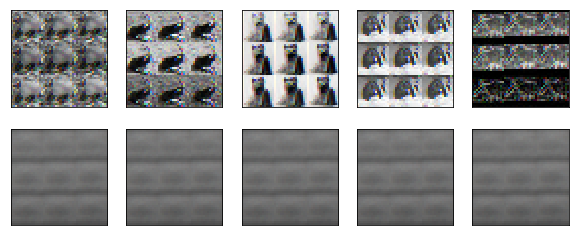


302it [00:30,  5.70it/s]
303it [00:30,  6.40it/s]
304it [00:30,  6.76it/s]
305it [00:30,  7.18it/s]
306it [00:30,  7.74it/s]
307it [00:30,  8.26it/s]
308it [00:30,  8.60it/s]
309it [00:30,  8.67it/s]
311it [00:31,  9.30it/s]
313it [00:31, 10.54it/s]
0it [00:00, ?it/s]
2it [00:00, 11.71it/s]
3it [00:00, 10.73it/s]
5it [00:00, 11.32it/s]
7it [00:00, 11.93it/s]
9it [00:00, 12.15it/s]
11it [00:00, 12.47it/s]
13it [00:01, 12.77it/s]
15it [00:01, 13.04it/s]
17it [00:01, 13.13it/s]
19it [00:01, 13.25it/s]
21it [00:01, 13.11it/s]
23it [00:01, 13.19it/s]
25it [00:01, 13.24it/s]
27it [00:02, 12.99it/s]
29it [00:02, 12.74it/s]
31it [00:02, 11.43it/s]
33it [00:02, 10.68it/s]
35it [00:02, 10.59it/s]
37it [00:03, 10.69it/s]
39it [00:03, 10.05it/s]
41it [00:03,  9.70it/s]
42it [00:03,  9.47it/s]
43it [00:03,  9.14it/s]
44it [00:03,  9.05it/s]
45it [00:03,  8.60it/s]
46it [00:04,  7.71it/s]
47it [00:04,  7.75it/s]
48it [00:04,  7.89it/s]
49it [00:04,  7.57it/s]
50it [00:04,  7.37it/s]
51it [00:04,  7

88it [00:10, 11.39it/s]
90it [00:10, 11.21it/s]
92it [00:10, 11.45it/s]
94it [00:10, 11.60it/s]
96it [00:10, 11.82it/s]
98it [00:11, 11.39it/s]
100it [00:11, 11.19it/s]
102it [00:11, 11.26it/s]
104it [00:11, 11.33it/s]
106it [00:11, 11.42it/s]
108it [00:11, 11.70it/s]
110it [00:12, 11.90it/s]
112it [00:12, 12.07it/s]
114it [00:12, 12.21it/s]
116it [00:12, 12.26it/s]
118it [00:12, 12.05it/s]
120it [00:12, 12.14it/s]
122it [00:13, 11.96it/s]
124it [00:13, 11.91it/s]
126it [00:13, 12.04it/s]
128it [00:13, 12.15it/s]
130it [00:13, 11.85it/s]
132it [00:13, 12.00it/s]
134it [00:14, 11.87it/s]
136it [00:14, 11.93it/s]
138it [00:14, 11.71it/s]
140it [00:14, 11.33it/s]
142it [00:14, 11.30it/s]
144it [00:15, 11.32it/s]
146it [00:15, 10.77it/s]
148it [00:15,  9.16it/s]
149it [00:15,  7.92it/s]
150it [00:15,  7.11it/s]
151it [00:16,  6.62it/s]
152it [00:16,  6.28it/s]
153it [00:16,  6.31it/s]
154it [00:16,  6.34it/s]
155it [00:16,  6.26it/s]
156it [00:16,  6.59it/s]
157it [00:16,  6.66it/s]
158it 

101it [00:14,  9.50it/s]
102it [00:14,  9.28it/s]
104it [00:14,  9.63it/s]
105it [00:14,  9.50it/s]
107it [00:15,  9.84it/s]
108it [00:15,  9.71it/s]
109it [00:15,  9.66it/s]
111it [00:15, 10.08it/s]
113it [00:15,  9.80it/s]
114it [00:15,  9.65it/s]
115it [00:15,  9.37it/s]
116it [00:15,  9.52it/s]
118it [00:16,  9.83it/s]
119it [00:16,  9.83it/s]
121it [00:16, 10.11it/s]
123it [00:16, 10.18it/s]
125it [00:16, 10.25it/s]
127it [00:16, 10.31it/s]
129it [00:17, 10.31it/s]
131it [00:17, 10.50it/s]
133it [00:17, 10.65it/s]
135it [00:17, 10.45it/s]
137it [00:17, 10.48it/s]
139it [00:18, 10.62it/s]
141it [00:18, 10.59it/s]
143it [00:18, 10.70it/s]
145it [00:18, 10.68it/s]
147it [00:18, 10.47it/s]
149it [00:19, 10.47it/s]
151it [00:19, 10.58it/s]
153it [00:19,  9.86it/s]
154it [00:19,  8.96it/s]
155it [00:19,  8.81it/s]
156it [00:19,  7.41it/s]
157it [00:20,  7.30it/s]
158it [00:20,  7.30it/s]
159it [00:20,  7.31it/s]
160it [00:20,  7.30it/s]
161it [00:20,  6.17it/s]
162it [00:20,  6.44it/s]


175it [00:21,  8.39it/s]
176it [00:22,  8.35it/s]
177it [00:22,  8.04it/s]
178it [00:22,  8.41it/s]
179it [00:22,  8.65it/s]
181it [00:22,  9.17it/s]
182it [00:22,  9.37it/s]
183it [00:22,  9.27it/s]
184it [00:22,  9.45it/s]
185it [00:23,  9.53it/s]
186it [00:23,  9.66it/s]
187it [00:23,  9.54it/s]
188it [00:23,  9.64it/s]
189it [00:23,  9.72it/s]
191it [00:23,  9.97it/s]
192it [00:23,  9.80it/s]
193it [00:23,  9.60it/s]
195it [00:24,  9.96it/s]
197it [00:24,  9.99it/s]
199it [00:24, 10.10it/s]
201it [00:24, 10.03it/s]
203it [00:24, 10.02it/s]
205it [00:24, 10.10it/s]
207it [00:25, 10.03it/s]
209it [00:25, 10.06it/s]
211it [00:25, 10.09it/s]
213it [00:25, 10.16it/s]
215it [00:25, 10.25it/s]
217it [00:26, 10.22it/s]
219it [00:26, 10.07it/s]
221it [00:26, 10.15it/s]
223it [00:26,  8.58it/s]
224it [00:27,  6.79it/s]
225it [00:27,  6.78it/s]
226it [00:27,  6.95it/s]
227it [00:27,  6.69it/s]
228it [00:27,  6.89it/s]
229it [00:27,  6.72it/s]
230it [00:28,  6.64it/s]
231it [00:28,  6.73it/s]


Epoch:  5 | train loss: 0.0564


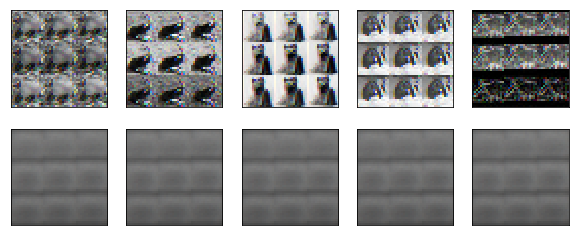


1it [00:00,  1.43it/s]
2it [00:00,  1.92it/s]
4it [00:00,  2.57it/s]
6it [00:01,  3.35it/s]
8it [00:01,  4.27it/s]
10it [00:01,  5.28it/s]
11it [00:01,  6.13it/s]
12it [00:01,  6.93it/s]
13it [00:01,  7.60it/s]
15it [00:01,  8.55it/s]
17it [00:02,  9.28it/s]
19it [00:02,  9.92it/s]
21it [00:02, 10.42it/s]
23it [00:02, 10.86it/s]
25it [00:02, 11.01it/s]
27it [00:02, 11.04it/s]
29it [00:03, 11.24it/s]
31it [00:03, 11.35it/s]
33it [00:03, 11.57it/s]
35it [00:03, 11.55it/s]
37it [00:03, 11.59it/s]
39it [00:04, 11.72it/s]
41it [00:04, 11.74it/s]
43it [00:04, 11.67it/s]
45it [00:04, 11.52it/s]
47it [00:04, 10.95it/s]
49it [00:04, 10.65it/s]
51it [00:05, 11.04it/s]
53it [00:05, 11.30it/s]
55it [00:05, 11.39it/s]
57it [00:05, 11.58it/s]
59it [00:05, 11.45it/s]
61it [00:05, 11.32it/s]
63it [00:06, 11.42it/s]
65it [00:06, 11.36it/s]
67it [00:06, 11.36it/s]
69it [00:06, 11.57it/s]
71it [00:06, 11.71it/s]
73it [00:07, 11.50it/s]
75it [00:07, 11.48it/s]
77it [00:07, 11.68it/s]
79it [00:07, 11.68it

Epoch:  5 | train loss: 0.0621


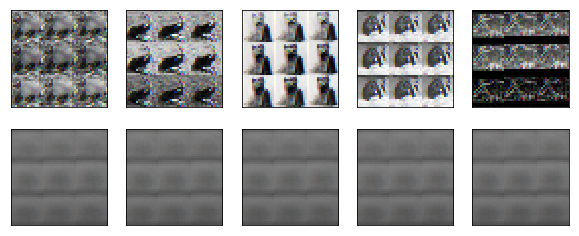


101it [00:09,  6.32it/s]
102it [00:09,  6.87it/s]
103it [00:10,  7.58it/s]
104it [00:10,  8.15it/s]
105it [00:10,  8.50it/s]
107it [00:10,  9.03it/s]
109it [00:10,  9.36it/s]
110it [00:10,  9.43it/s]
111it [00:10,  9.50it/s]
112it [00:10,  9.30it/s]
113it [00:11,  9.49it/s]
114it [00:11,  9.55it/s]
115it [00:11,  9.40it/s]
116it [00:11,  9.51it/s]
118it [00:11,  9.80it/s]
119it [00:11,  9.65it/s]
120it [00:11,  9.58it/s]
121it [00:11,  9.70it/s]
122it [00:12,  9.31it/s]
123it [00:12,  9.37it/s]
124it [00:12,  9.40it/s]
125it [00:12,  9.39it/s]
126it [00:12,  9.33it/s]
127it [00:12,  9.27it/s]
128it [00:12,  9.36it/s]
130it [00:12,  9.62it/s]
131it [00:12,  9.46it/s]
132it [00:13,  9.49it/s]
133it [00:13,  9.46it/s]
134it [00:13,  9.34it/s]
135it [00:13,  9.24it/s]
136it [00:13,  9.37it/s]
137it [00:13,  9.41it/s]
138it [00:13,  9.34it/s]
139it [00:13,  9.46it/s]
140it [00:13,  9.42it/s]
141it [00:14,  9.50it/s]
142it [00:14,  9.60it/s]
143it [00:14,  9.61it/s]
145it [00:14,  9.82it/s]

Epoch:  5 | train loss: 0.0724


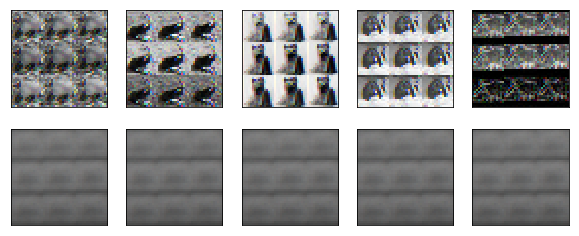


201it [00:20,  3.78it/s]
202it [00:21,  4.60it/s]
203it [00:21,  5.47it/s]
204it [00:21,  6.31it/s]
205it [00:21,  7.08it/s]
206it [00:21,  7.49it/s]
208it [00:21,  8.26it/s]
209it [00:21,  8.68it/s]
211it [00:21,  9.24it/s]
213it [00:22,  9.65it/s]
215it [00:22,  9.86it/s]
217it [00:22, 10.17it/s]
219it [00:22, 10.42it/s]
221it [00:22, 10.36it/s]
223it [00:23, 10.41it/s]
225it [00:23, 10.45it/s]
227it [00:23, 10.24it/s]
229it [00:23, 10.16it/s]
231it [00:23, 10.14it/s]
233it [00:24, 10.01it/s]
235it [00:24, 10.10it/s]
237it [00:24, 10.07it/s]
239it [00:24,  9.23it/s]
240it [00:24,  9.41it/s]
241it [00:24,  9.53it/s]
242it [00:25,  9.36it/s]
243it [00:25,  9.40it/s]
244it [00:25,  9.27it/s]
245it [00:25,  9.33it/s]
246it [00:25,  9.37it/s]
247it [00:25,  9.45it/s]
248it [00:25,  9.58it/s]
249it [00:25,  9.60it/s]
250it [00:25,  9.62it/s]
251it [00:26,  9.65it/s]
252it [00:26,  9.46it/s]
253it [00:26,  9.58it/s]
254it [00:26,  9.68it/s]
255it [00:26,  9.70it/s]
256it [00:26,  9.62it/s]

Epoch:  5 | train loss: 0.0573


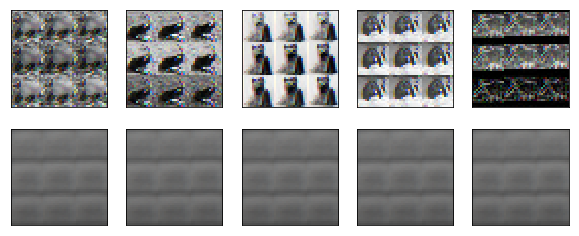


301it [00:31,  5.89it/s]
303it [00:31,  6.85it/s]
304it [00:31,  7.35it/s]
305it [00:32,  7.97it/s]
306it [00:32,  8.46it/s]
307it [00:32,  8.84it/s]
308it [00:32,  9.06it/s]
309it [00:32,  8.99it/s]
310it [00:32,  8.94it/s]
311it [00:32,  9.17it/s]
312it [00:32,  9.21it/s]
313it [00:32,  9.53it/s]
0it [00:00, ?it/s]
1it [00:00,  9.89it/s]
2it [00:00,  9.70it/s]
3it [00:00,  9.68it/s]
5it [00:00,  9.99it/s]
7it [00:00, 10.21it/s]
9it [00:00, 10.45it/s]
11it [00:01, 10.56it/s]
12it [00:01, 10.37it/s]
13it [00:01, 10.22it/s]
14it [00:01,  9.91it/s]
16it [00:01, 10.21it/s]
18it [00:01,  9.99it/s]
19it [00:01,  9.26it/s]
20it [00:01,  9.40it/s]
22it [00:02,  9.78it/s]
23it [00:02,  9.77it/s]
24it [00:02,  9.57it/s]
26it [00:02,  9.92it/s]
28it [00:02, 10.15it/s]
30it [00:02, 10.25it/s]
32it [00:03, 10.33it/s]
34it [00:03, 10.46it/s]
36it [00:03, 10.34it/s]
38it [00:03, 10.34it/s]
40it [00:03, 10.30it/s]
42it [00:04, 10.34it/s]
44it [00:04, 10.46it/s]
46it [00:04, 10.40it/s]
48it [00:04, 1

100it [00:12,  6.52it/s]
101it [00:12,  6.10it/s]
102it [00:12,  5.92it/s]
103it [00:13,  5.77it/s]
104it [00:13,  5.82it/s]
105it [00:13,  5.92it/s]
106it [00:13,  5.22it/s]
107it [00:13,  5.40it/s]
108it [00:14,  5.94it/s]
109it [00:14,  6.55it/s]
110it [00:14,  7.07it/s]
111it [00:14,  7.27it/s]
112it [00:14,  6.99it/s]
113it [00:14,  6.72it/s]
114it [00:14,  5.92it/s]
115it [00:15,  5.70it/s]
116it [00:15,  5.70it/s]
117it [00:15,  5.72it/s]
118it [00:15,  5.71it/s]
119it [00:15,  5.67it/s]
120it [00:16,  5.56it/s]
121it [00:16,  5.81it/s]
122it [00:16,  5.28it/s]
123it [00:16,  5.40it/s]
124it [00:16,  5.73it/s]
125it [00:16,  6.03it/s]
126it [00:17,  5.98it/s]
127it [00:17,  6.18it/s]
128it [00:17,  6.33it/s]
129it [00:17,  6.25it/s]
130it [00:17,  5.99it/s]
131it [00:17,  5.95it/s]
132it [00:18,  6.00it/s]
133it [00:18,  6.02it/s]
134it [00:18,  6.19it/s]
135it [00:18,  6.13it/s]
136it [00:18,  5.98it/s]
137it [00:18,  6.06it/s]
138it [00:19,  5.94it/s]
139it [00:19,  5.85it/s]


KeyboardInterrupt: 

In [73]:
# Hyper Parameters
epochs = 10
lr = 0.005 
n_plots = 5

# prepare original data for plotting
view_data = train_dataset.get_train_data(n_plots)#.type(torch.FloatTensor)# / 255.

autoencoder = AutoEncoder(latent_dim=3, image_size=48, channel_num=3)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=lr)
loss_func = loss = nn.MSELoss()


for epoch in range(epochs):
    for step, (x, y) in tqdm.tqdm(enumerate(train_loader)):
        x = x.view(-1, 3 * 48 * 48)
#         print(x.shape)
        encoded, decoded = autoencoder(x) 
        y = y.view(-1, 3 * 48 * 48)
        loss = loss_func(decoded, y) 
        optimizer.zero_grad()   # clear gradients for this training step
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients

        if step % 100 == 0 and epoch in [0, 5, epochs - 1]:
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.item())

            # plotting decoded image (second row)
            
            data_in = view_data.view(-1, 3 * 48 * 48)
            _, decoded_data = autoencoder(data_in)
            
            plot_digits(view_data, decoded_data, image_size=48)


In [40]:
test_dataset = DenoisingDataset(data_path, 
                                train=False,
                                transform=transforms.Compose([
                                   torchvision.transforms.ToTensor()
                                   torchvision.transforms.Lambda(lambda x: x.flatten())
                                ]))

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
decoded_samples = []

for step, x in enumerate(test_loader):
    
    en_x, de_x = autoencoder(x)
    decoded_samples.append(de_x.detach().numpy())
    # encode the points into the latent space and save for later estimation
    
sampled_z = np.concatenate(samples, axis=0)